# Pancreatic cancer - Vundavilli 2020

Model from the paper: DOI: 10.1109/TCBB.2018.2872573 (link: https://www.ncbi.nlm.nih.gov/pubmed/30281473)


In [2]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import itertools
# import booleanNetwork module from ./src
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix  

## Mutation profiles (celllines)

Test on the cell lines whose mutations are covered by the model.  
According to the PC cell line mutation data provided by GDSC, only two mutations are covered by the model: **MAP2K4 (MKK4) and KRAS (RAS)**.

In [3]:
# Dic file to specify how should the values of the genes be changed when mutated, 
# e.g. oncogene 'FLT3 = 1', TSG 'TP53 = 0'
# These genes will be set constant during the whole computation process.

mutations_dict = {'MKK4': 0, 'RAS': 1}

# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {}
cell_profiles['Normal'] = ''
cell_profiles['RAS_mutated'] = 'RAS' # KP4
cell_profiles['MKK4_mutated'] = 'MKK4' # cell line that only has MKK4 mutation doesn't exist in GDSC
cell_profiles['RAS_MKK4_mutated'] = 'RAS,MKK4' # CAPAN1

## Perturbations (drugs)

Drug effects are described in the paper. (3.1 Drug Interventions)

In [4]:
drugs = ['Untreated', 'Cryptotanshinone', 'LY294002', 'Temsirolimus', 'Lapatinib', 'HO-3867']
drug_knockouts = {'Cryptotanshinone': ['STAT3', 'ERK1_2'],
                  'LY294002': ['PIK3CA'],
                  'Temsirolimus': ['mTOR'], 
                  'Lapatinib': ['EGFR', 'EFGR', 'ERBB2'],
                  'HO-3867': ['STAT3'],
                  'Untreated': []
                 }
# Combination of drugs in pairs
double_drugs = list(itertools.combinations([d for d in drugs if d != 'Untreated'], 2))
double_drug_names = [f"{d1}+{d2}" for d1, d2 in double_drugs]
all_treatments = drugs + double_drug_names

## Simulation - without noise

As performed by Yue, simulate 27 steps with no noise.


In [5]:
file = 'input_files/pancreatic_vundavilli_2020_fig3.txt'

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)
network = BMatrix.load_network_from_file(file)
ngenes = len(equations)
input_genes = ['PTEN', 'LKB1', 'EGF', 'HBEGF', 'IGF', 'NRG1']
output_genes = ['CCND1', 'BCL2', 'SRFELK1', 'FOS-JUN', 'SRFELK4', 'SP1']

No initial state provided, using a random initial state


Calculation of the size difference between the output of the model and the ideal output is as in the paper.   
The ideal output is output_genes = [000000], which also corresponds to a lack of cell proliferation and a non-suppression of apoptosis.

In [6]:
# Calculate size difference as the output of the model
df_size_differences_bi = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)

# Define a function to calculate size difference
def calculate_size_difference_bi(output_values):
    """
    Calculate the size difference metric between the actual output and ideal output (all zeros).
    
    Based on the formula d_s(a,b) = ((B+C)/(A+B+C+D))^2, where:
    - A: count of positions where both vectors have 1 (matches of 1s)
    - B: count of positions where a=0, b=1 (mismatches)
    - C: count of positions where a=1, b=0 (mismatches)
    - D: count of positions where both vectors have 0 (matches of 0s)
    
    For our case, the ideal vector b is all zeros, so:
    - A = 0 (no positions where both are 1)
    - B = 0 (no positions where actual=0, ideal=1)
    - C = sum(output_values) (counts of 1s in actual output)
    - D = len(output_values) - sum(output_values) (counts of 0s in actual output)
    
    This simplifies to: d_s(a,b) = (C/(C+D))^2 = (sum(output_values)/len(output_values))^2
    """
    total_positions = len(output_values)
    mismatches = sum(output_values)  # C: positions where actual=1, ideal=0
    
    if total_positions == 0:
        return 0.0
    else:
        proportion_mismatches = mismatches / total_positions
        return proportion_mismatches ** 2

In [88]:
# Raw output values for each cell line and treatment
output_values_dict_bi = {cell_line: {treatment: None for treatment in all_treatments} 
                     for cell_line in cell_profiles.keys()}

# Process each cell line
for cell_line, mutation_profile in cell_profiles.items():
    print(f"Processing cell line: {cell_line}")
    mutations = mutation_profile.split(',') if mutation_profile else []
    
    # Process each drug treatment
    for drug in drugs:
        print(f"  Testing drug: {drug}")

        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations based on cell line 
        for gene in mutations:
            if gene.strip(): 
                network.knockout(gene, mutations_dict[gene])
       
        # drug effects
        for ko_gene in drug_knockouts[drug]:
            network.knockout(ko_gene, 0)
        
        # Run simulation 
        results = network.update(27) 
        output_values = [results[-1, network.nodeDict[k]] for k in output_genes]
        output_values_dict_bi[cell_line][drug] = output_values
        size_diff = calculate_size_difference_bi(output_values)
        df_size_differences_bi.loc[cell_line, drug] = size_diff
    
    # Process each double drug combination
    for idx, (d1, d2) in enumerate(double_drugs):
        combo_name = f"{d1}+{d2}"
        print(f"  Testing drug combination: {combo_name}")
        
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations
        for gene in mutations:
            if gene.strip():  # Skip empty strings
                network.knockout(gene, mutations_dict[gene])
        
        # combined drug effects
        for ko_gene in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko_gene, 0)
        
        # Run simulation 
        results = network.update(27)
        output_values = [results[-1, network.nodeDict[k]] for k in output_genes]
        output_values_dict_bi[cell_line][combo_name] = output_values
        size_diff = calculate_size_difference_bi(output_values)
        df_size_differences_bi.loc[cell_line, combo_name] = size_diff
    
    print("--------------------------------")

Processing cell line: Normal
  Testing drug: Untreated
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: Cryptotanshinone+LY294002
  Testing drug combination: Cryptotanshinone+Temsirolimus
  Testing drug combination: Cryptotanshinone+Lapatinib
  Testing drug combination: Cryptotanshinone+HO-3867
  Testing drug combination: LY294002+Temsirolimus
  Testing drug combination: LY294002+Lapatinib
  Testing drug combination: LY294002+HO-3867
  Testing drug combination: Temsirolimus+Lapatinib
  Testing drug combination: Temsirolimus+HO-3867
  Testing drug combination: Lapatinib+HO-3867
--------------------------------
Processing cell line: RAS_mutated
  Testing drug: Untreated
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: Cryptotanshinone+LY294002
  Testing drug c

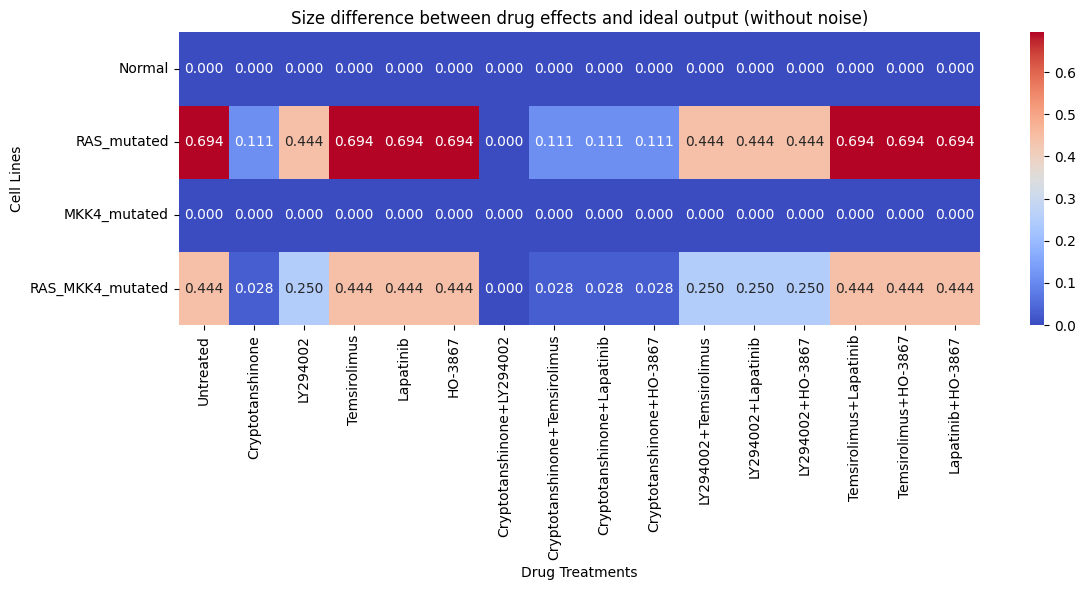

In [89]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_size_differences_bi.astype(float), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Size difference between drug effects and ideal output (without noise)")
plt.ylabel("Cell Lines")
plt.yticks(rotation=0)
plt.xlabel("Drug Treatments")
plt.tight_layout()
plt.show()

# Interpretation: 
# - Blue: size difference is 0 means that the output is the same as the ideal output 
#   with normal apoptosis and no proliferation.
# - Red: size difference is 1 means that the output is the opposite of the ideal output 
#   with no apoptosis and high proliferation.

The results are all zeros for both normal cell and MKK4_mutated cell, meaning that they are all the same as the ideal output, which implies that MKK4 mutation is non-informative (or non-harmful) for the model.  And the drugs have no effect on normal and MKK4_mutated cell lines.

I think this is because the model is not able to capture the dynamics of these cell lines, as in the paper, they tested all possible mutations and only show the distribution of the results, where there are cases with all zeros.  

It would be interesting to see if the model can perform differently with noise.


## Simulation - with noise
### First, test for convergence
Simulate 10000 steps with noise 0.05 for each cell line with no drug treatment.

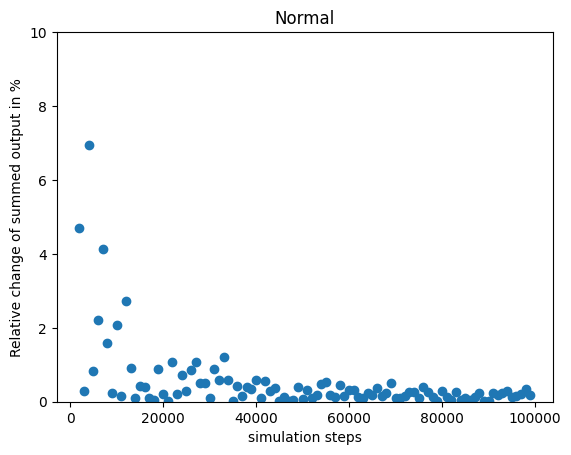

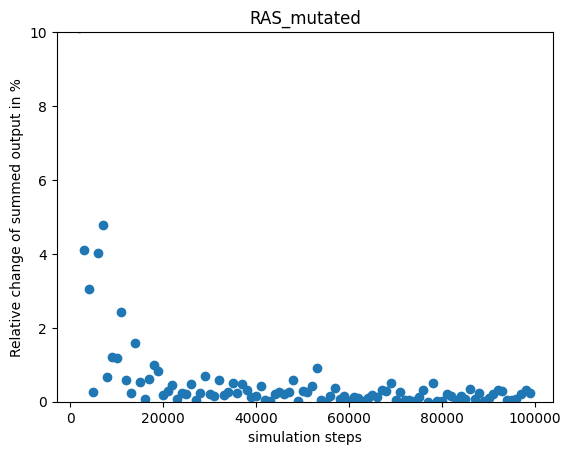

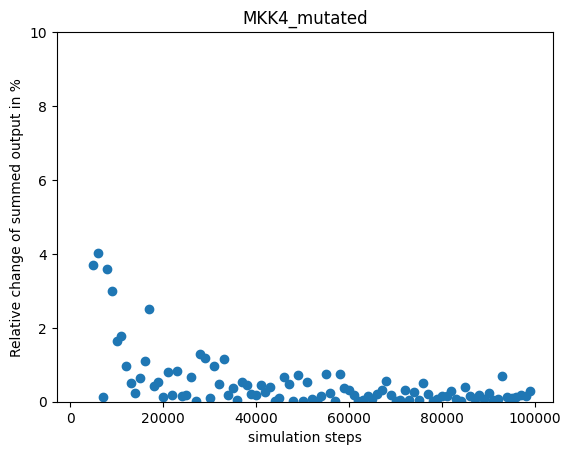

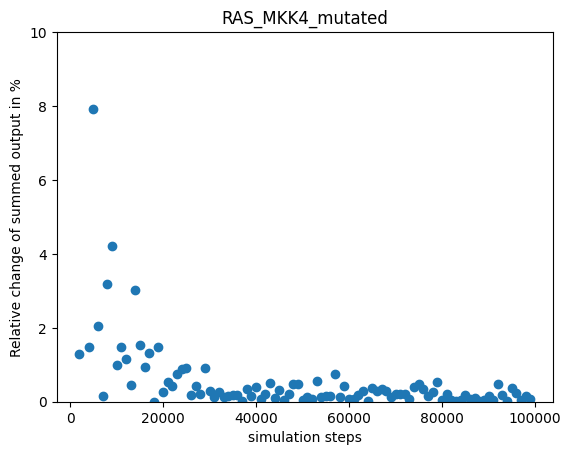

In [50]:
# Test for convergence
n = 100000
noise = 0.05
steps = list(range(1000, 100000, 1000))
scores_steps = {}
for cell_line, mutation_profile in cell_profiles.items():
    scores = []
    scores_array = []
    mutations = mutation_profile.split(',') if mutation_profile else []
    # mutations based on cell line 
    for gene in mutations:
        if gene.strip(): 
            network.knockout(gene, mutations_dict[gene])
    network.setInitialValue('PTEN', 1)
    network.setInitialValue('LKB1', 1)
    network.setInitialValue('EGF', 0)
    network.setInitialValue('HBEGF', 0)
    network.setInitialValue('IGF', 0)
    network.setInitialValue('NRG1', 0)

    network_traj = network.update_noise(noise, step)
    for step in steps:
        cal_range = network_traj[step//2:step]
        average_array = np.mean(cal_range, axis=0)
        output_values = [average_array[network.nodeDict[k]] for k in output_genes]
        scores_array.append(output_values) 
        scores.append(np.sum(output_values)) # take the sum of all the output values
    scores_steps.update({cell_line: scores})

for cell_line in cell_profiles:
    scores = scores_steps[cell_line]
    
    # compute the difference in scores
    rel_diff_scores = []
    for i in range(1, len(scores)):
        diff = scores[i] - scores[i - 1]
        rel_diff_scores.append(100*abs(diff))
    
    
    fig = plt.figure()
    plt.scatter(steps[1:], rel_diff_scores)
    plt.xlabel('simulation steps')
    plt.ylabel('Relative change of summed output in %')
    plt.ylim(0, 10)
    plt.title(f'{cell_line}')
    plt.show()

### Use normal, untreated as baseline

I will use normal, untreated as baseline (ideal output) to calculate the size difference.

And since the output value is now non-binary, we need to calculate the size difference differently.

In [90]:
# Process the Normal cell line first to establish baseline
cell_line = 'Normal'
drug = 'Untreated'
network.undoKnockouts()
network.setInitialValue('PTEN', 1)
network.setInitialValue('LKB1', 1)
network.setInitialValue('EGF', 0)
network.setInitialValue('HBEGF', 0)
network.setInitialValue('IGF', 0)
network.setInitialValue('NRG1', 0)
n = 100000
noise = 0.05

all_treatments = drugs + double_drug_names
df_size_differences = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)
output_values_dict = {cell_line: {treatment: None for treatment in all_treatments} 
                     for cell_line in cell_profiles.keys()}

baseline_traj = network.update_noise(noise, n)
cal_range = baseline_traj[n//2:n]
baseline_average = np.mean(cal_range, axis=0)
baseline_output = [baseline_average[network.nodeDict[k]] for k in output_genes]
print(f"Baseline output values for output genes: {baseline_output}")
output_values_dict[cell_line][drug] = baseline_output
df_size_differences.loc[cell_line, drug] = 0.0

# Calculate size difference for non-binary (continuous) values
def calculate_size_difference(output_values, ideal_output = baseline_output):
    """
    Calculate the size difference metric between the actual output and ideal output
    for non-binary (continuous) values resulting from averaging over multiple timesteps.
    
    - For each position i, we calculate the deviation from the ideal state
    - We square the deviations to penalize larger differences more heavily
    - We average these squared deviations across all positions
    
    This gives us a measure between 0 and 1 where:
    - 0 means perfect match with ideal output
    - 1 means maximum possible deviation from ideal output
    """

    # Calculate sum of squared deviations
    sum_squared_deviations = 0
    for i in range(len(output_values)):
        deviation = output_values[i] - ideal_output[i]
        sum_squared_deviations += deviation ** 2
    
    # Normalize by number of positions
    if len(output_values) == 0:
        return 0.0
    else:
        # This gives mean squared deviation - a value between 0 and 1
        return sum_squared_deviations / len(output_values)

Baseline output values for output genes: [0.76266, 0.4927, 0.7471, 0.75088, 0.75136, 0.7487]


In [91]:
n = 100000
noise = 0.05

# Process each cell line
for cell_line, mutation_profile in cell_profiles.items():
    print(f"Processing cell line: {cell_line}")
    print(f"Mutation profile: {mutation_profile}")
    mutations = mutation_profile.split(',') if mutation_profile else []
    
    # Process each drug treatment
    for drug in drugs:
        if cell_line == 'Normal' and drug == 'Untreated':
            # Skip - already processed as baseline
            continue

        print(f"  Testing drug: {drug}")
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations based on cell line 
        for gene in mutations:
            if gene.strip(): 
                network.knockout(gene, mutations_dict[gene])
       
        # drug effects
        for ko_gene in drug_knockouts[drug]:
            network.knockout(ko_gene, 0)
        
        # Run simulation for n steps and take the average of the last half of the simulation trajectory
        results = network.update_noise(noise, n) 
        cal_range = results[n//2:n]
        average_array = np.mean(cal_range, axis=0)
        output_values = [average_array[network.nodeDict[k]] for k in output_genes]
        output_values_dict[cell_line][drug] = output_values
        size_diff = calculate_size_difference(output_values,baseline_output)
        df_size_differences.loc[cell_line, drug] = size_diff
    
    # Process each double drug combination
    for idx, (d1, d2) in enumerate(double_drugs):
        combo_name = f"{d1}+{d2}"
        print(f"  Testing drug combination: {combo_name}")
        
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations
        for gene in mutations:
            if gene.strip():  # Skip empty strings
                network.knockout(gene, mutations_dict[gene])
        
        # combined drug effects
        for ko_gene in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko_gene, 0)
        
        # Run simulation 
        network_traj = network.update_noise(noise, n)
        cal_range = network_traj[n//2:n]
        average_array = np.mean(cal_range, axis=0)

        output_values = [average_array[network.nodeDict[k]] for k in output_genes]
        output_values_dict[cell_line][combo_name] = output_values
        size_diff = calculate_size_difference(output_values,baseline_output)
        df_size_differences.loc[cell_line, combo_name] = size_diff
    
    print("--------------------------------")

Processing cell line: Normal
Mutation profile: 
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: Cryptotanshinone+LY294002
  Testing drug combination: Cryptotanshinone+Temsirolimus
  Testing drug combination: Cryptotanshinone+Lapatinib
  Testing drug combination: Cryptotanshinone+HO-3867
  Testing drug combination: LY294002+Temsirolimus
  Testing drug combination: LY294002+Lapatinib
  Testing drug combination: LY294002+HO-3867
  Testing drug combination: Temsirolimus+Lapatinib
  Testing drug combination: Temsirolimus+HO-3867
  Testing drug combination: Lapatinib+HO-3867
--------------------------------
Processing cell line: RAS_mutated
Mutation profile: RAS
  Testing drug: Untreated
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: Cryptotanshinone+LY294002
 

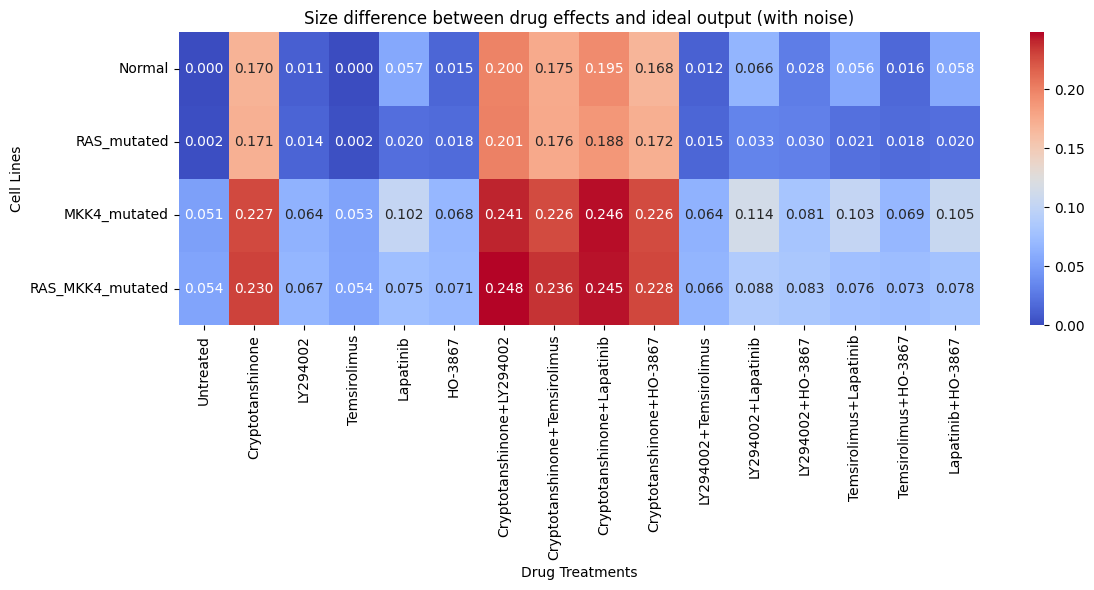

In [92]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_size_differences.astype(float), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Size difference between drug effects and ideal output (with noise)")
plt.ylabel("Cell Lines")
plt.yticks(rotation=0)
plt.xlabel("Drug Treatments")
plt.tight_layout()
plt.show()

# Interpretation of the results: 
# - Blue: size difference is 0 means that the output is the same as normal, untreated with normal apoptosis and no proliferation.
# - Red: size difference is 1 means that the output is the opposite of the ideal output with no apoptosis and high proliferation.

The results are hard to interpret, it seems that drug treatments only do harm with a larger size difference compared to untreated. 

### Use all zeros as baseline

Since the previous results do not make sense, I will use all zeros as baseline (ideal output) to calculate the size difference, as similar to the original analysis in the publication.

In [10]:
n = 100000
noise = 0.05
df_size_differences = pd.DataFrame(index=cell_profiles.keys(), columns=all_treatments)
output_values_dict = {cell_line: {treatment: None for treatment in all_treatments} 
                     for cell_line in cell_profiles.keys()}

# Process each cell line
for cell_line, mutation_profile in cell_profiles.items():
    print(f"Processing cell line: {cell_line}")
    print(f"Mutation profile: {mutation_profile}")
    mutations = mutation_profile.split(',') if mutation_profile else []
    
    # Process each drug treatment
    for drug in drugs:
        print(f"  Testing drug: {drug}")
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations based on cell line 
        for gene in mutations:
            if gene.strip(): 
                network.knockout(gene, mutations_dict[gene])
       
        # drug effects
        for ko_gene in drug_knockouts[drug]:
            network.knockout(ko_gene, 0)
        
        # Run simulation for n steps and take the average of the last half of the simulation trajectory
        results = network.update_noise(noise, n) 
        cal_range = results[n//2:n]
        average_array = np.mean(cal_range, axis=0)
        output_values = [average_array[network.nodeDict[k]] for k in output_genes]
        output_values_dict[cell_line][drug] = output_values
        size_diff = calculate_size_difference_bi(output_values)
        df_size_differences.loc[cell_line, drug] = size_diff
    
    # Process each double drug combination
    for idx, (d1, d2) in enumerate(double_drugs):
        combo_name = f"{d1}+{d2}"
        print(f"  Testing drug combination: {combo_name}")
        
        network.undoKnockouts()
        network.setInitialValue('PTEN', 1)
        network.setInitialValue('LKB1', 1)
        network.setInitialValue('EGF', 0)
        network.setInitialValue('HBEGF', 0)
        network.setInitialValue('IGF', 0)
        network.setInitialValue('NRG1', 0)
        
        # mutations
        for gene in mutations:
            if gene.strip():  # Skip empty strings
                network.knockout(gene, mutations_dict[gene])
        
        # combined drug effects
        for ko_gene in drug_knockouts[d1] + drug_knockouts[d2]:
            network.knockout(ko_gene, 0)
        
        # Run simulation 
        network_traj = network.update_noise(noise, n)
        cal_range = network_traj[n//2:n]
        average_array = np.mean(cal_range, axis=0)

        output_values = [average_array[network.nodeDict[k]] for k in output_genes]
        output_values_dict[cell_line][combo_name] = output_values
        size_diff = calculate_size_difference_bi(output_values)
        df_size_differences.loc[cell_line, combo_name] = size_diff
    
    print("--------------------------------")

Processing cell line: Normal
Mutation profile: 
  Testing drug: Untreated
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: Cryptotanshinone+LY294002
  Testing drug combination: Cryptotanshinone+Temsirolimus
  Testing drug combination: Cryptotanshinone+Lapatinib
  Testing drug combination: Cryptotanshinone+HO-3867
  Testing drug combination: LY294002+Temsirolimus
  Testing drug combination: LY294002+Lapatinib
  Testing drug combination: LY294002+HO-3867
  Testing drug combination: Temsirolimus+Lapatinib
  Testing drug combination: Temsirolimus+HO-3867
  Testing drug combination: Lapatinib+HO-3867
--------------------------------
Processing cell line: RAS_mutated
Mutation profile: RAS
  Testing drug: Untreated
  Testing drug: Cryptotanshinone
  Testing drug: LY294002
  Testing drug: Temsirolimus
  Testing drug: Lapatinib
  Testing drug: HO-3867
  Testing drug combination: C

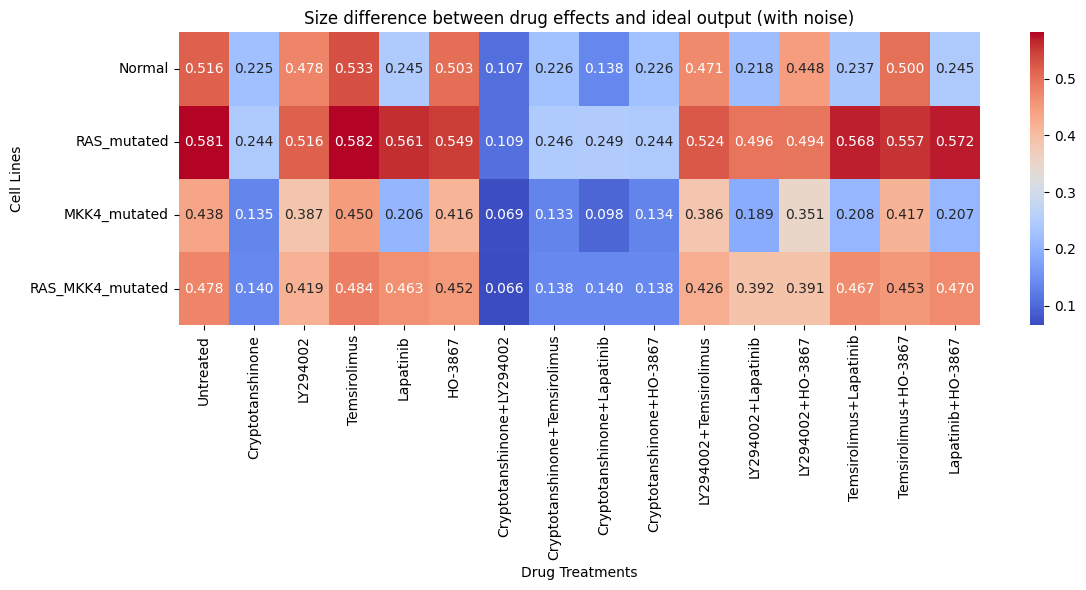

In [95]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_size_differences.astype(float), annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Size difference between drug effects and ideal output (with noise)")
plt.ylabel("Cell Lines")
plt.yticks(rotation=0)
plt.xlabel("Drug Treatments")
plt.tight_layout()
plt.show()

# Interpretation of the results: 
# - Blue: size difference is 0 means that the output is the same as normal, untreated with normal apoptosis and no proliferation.
# - Red: size difference is 1 means that the output is the opposite of the ideal output with no apoptosis and high proliferation.

From the results, it seems that MKK4 mutation (loss of function here) is a protective factor for the model, suggesting that MKK4 functions as an oncogene. 

In this model, MKK4 locates downstream of RAS, and is just used as part of the MAPK pathway (RAS -> MEKK1 -> MKK4 -> JNK1). Which explains why its loss of function is protective.

"MKK4’s role in tumor development is controversial as it can both act as a tumor suppressor and a tumor promoter."  
-- Katzengruber et al. 2023 https://doi.org/10.3390/ijms24087495 
   
"These results argue that MKK4 functions as a pro-oncogenic molecule instead of a suppressor in breast and pancreatic tumors."  
-- Wang et al. 2004 https://doi.org/10.1038/sj.onc.1207802 